# <center>Phase 2 - Publication<center>

In [1]:
# General imports.
import sqlite3
import pandas as pd
from matplotlib_venn import venn2, venn3
import scipy.stats as scs
import textwrap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from  itertools import combinations
import os
from matplotlib.colors import ListedColormap
from matplotlib import ticker
from scipy.stats import ttest_ind
import math
from timeit import default_timer as timer

# Imports from neighbor directories.
import sys
sys.path.append("..")
from src.utilities import field_registry as fieldreg

# IPython magics for this notebook.
%matplotlib inline

# Use latex font for matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
# Timing
NOTEBOOK_START = timer()

# Switches
SAVE_OUTPUT = False

# Data Globals
FR = fieldreg.FieldRegistry()
TOTAL_USERS = 0
REMAINING_USERS = 0
TOTAL_DOGS = 0
REMAINING_DOGS = 0
PREVALENCE = lambda x: (x / REMAINING_DOGS) * 100
CATEGORY_MATRIX = pd.DataFrame()

# Bootstrap Globals
NITER=10000
PREVALENCE_CI=True
ODDS_RATIO_CI=False

# Database Globals
USER_TABLE = 'users'
DOG_TABLE = 'dogs'
BIAS_FILTER = '''
    USING (record_id)
    WHERE question_reason_for_part_3 = 0
    OR (question_reason_for_part_3 = 1 AND q01_main != 1)'''
CON = sqlite3.connect('../data/processed/processed.db')

In [3]:
def createStringDataFrame(table, fields, labels, filtered=True):
    query = 'SELECT ' + fields + ' FROM ' + table
    if filtered:
        table2 = USER_TABLE if table == DOG_TABLE else DOG_TABLE
        query += ' JOIN ' + table2 + ' ' + BIAS_FILTER
    df = pd.read_sql_query(query, CON)
    df.columns = labels
    return df

def convertToNumeric(df):
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

def createNumericDataFrame(table, fields, labels, filtered=True):
    df = createStringDataFrame(table, fields, labels, filtered)
    return convertToNumeric(df)

def replaceFields(df, column, replacement_dict):
    df[column].replace(replacement_dict, inplace=True)

def getValueCountAndPrevalence(df, field):
    s = df[field].value_counts()
    #p = s.apply(PREVALENCE).round(2)
    p = s.apply(PREVALENCE)
    rv = pd.concat([s, p], axis=1)
    rv.columns = ['frequency', 'prevalence']
    return rv

def createCategoryMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = p
        pvalue[pair[1]][pair[0]] = p
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def createQuestionMatrix():
    fields = ''
    for cat, sublist in FR.fields.items():
        for field in sublist:
            fields += '{}, '.format(field)
    fields = fields[:-2]
    labels = []
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            labels.append(key)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = p
        pvalue[pair[1]][pair[0]] = p
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def createCorrelationMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    return df.corr()

def createOddsRatioMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = getOddsRatio(contingency)
        pvalue[pair[1]][pair[0]] = getOddsRatio(contingency)
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def displayOddsRatio(df):
    odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(df)
    print('OR = %.2f, 95%% CI: %.2f-%.2f, n = %d'
          %(round(odds, 2), round(ci_low, 2), round(ci_high, 2), tot))

def getOddsRatio(df):
    return (df[1][1]/df[1][0])/(df[0][1]/df[0][0])

def getOddsRatioAndConfidenceInterval(df):
    odds = 0
    ci_low = 0
    ci_high = 0
    tot = 0
    odds = getOddsRatio(df)
    if odds != 0:
        nl_or = math.log(odds)
        se_nl_or = math.sqrt((1/df[0][0])+(1/df[0][1])+(1/df[1][0])+(1/df[1][1]))
        ci_low = math.exp(nl_or - (1.96 * se_nl_or))
        ci_high = math.exp(nl_or + (1.96 * se_nl_or))
        tot = df[0][0] + df[0][1] + df[1][0] + df[1][1]
    return odds, ci_low, ci_high, tot

def get_significance_category(p):
    if np.isnan(p):
        return p
    elif p > 10**(-3):
        return -1
    elif p <= 10**(-3) and p > 10**(-6):
        return 0
    else:
        return 1
    
def displaySeriesMedian(s, units=""):
    print('MD = %.2f %s (SD = %.2f, min = %.2f, max = %.2f, n = %d)'
          %(round(s.median(), 2), units, round(s.std(), 2), round(s.min(), 2), round(s.max(), 2), s.count()))
    
def displaySeriesMean(s, units=""):
    print('M = %.2f %s (SD = %.2f, min = %.2f, max = %.2f, n = %d)'
          %(round(s.mean(), 2), units, round(s.std(), 2), round(s.min(), 2), round(s.max(), 2), s.count()))
    
def convert_to_binary_response(x, y=1):
    x = float(x)
    if x < y:
        return 0
    return 1
        
def exportTable(data, title):
    if not SAVE_OUTPUT:
        return
    file_ = os.path.join('..', 'reports', 'tables', title) + '.tex'
    with open(file_, 'w') as tf:
        tf.write(r'\documentclass[varwidth=\maxdimen]{standalone}\usepackage{booktabs}\begin{document}')
        tf.write(df.to_latex())
        tf.write(r'\end{document}')
        
def exportFigure(figure, title):
    if not SAVE_OUTPUT:
        return
    file_ = os.path.join('..', 'reports', 'figures', title) + '.pdf'
    figure.tight_layout()
    figure.savefig(file_, format='pdf')

In [4]:
def get_bootstrap_prevalence_ci(data, count=10, alpha=0.95):
    start = timer()
    temp_df = pd.DataFrame()
    for i in range(count):
        sample_df = data.sample(len(data.index), replace=True)
        sums = sample_df.sum().apply(PREVALENCE)
        temp_df = temp_df.append(sums, ignore_index=True)
    lower = (1-alpha)/2
    upper = alpha+lower
    for name, values in temp_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(round(values[int(lower * len(values))], 2))
        print(round(values[int(upper * len(values))], 2))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

## <center>Demographics</center>

### Number of participants:

In [5]:
df = createNumericDataFrame(USER_TABLE, 'COUNT(*)', ['count'], filtered=False)
# Assign value to global.
TOTAL_USERS = df['count'][0]
print('N = %d owners [unadjusted]' %TOTAL_USERS)

N = 3201 owners [unadjusted]


### Number of participating dogs:

In [6]:
df = createNumericDataFrame(DOG_TABLE, 'COUNT(*)', ['count'], filtered=False)
# Assign value to global.
TOTAL_DOGS = df['count'][0]
print('N = %d dogs [unadjusted]' %TOTAL_DOGS)

N = 5018 dogs [unadjusted]


### Suspicion of behavior problems as one of multiple motivating factors:

In [7]:
fields = ('question_reason_for_part_1, question_reason_for_part_2, '
          'question_reason_for_part_3, question_reason_for_part_4, '
          'question_reason_for_part_5')
labels = ['love for dogs', 'you help shelter animals', 'suspicion of behavior problems',
          'work with animals', 'other']
df = createNumericDataFrame(USER_TABLE, fields, labels, filtered=False)
df = df[df[labels[2]] == 1]
df['sum'] = df.sum(axis=1)
s = df.sum(0, skipna=False)

print('n = %d owners (%d%%) [unadjusted]' %(s.iloc[2], round((s.iloc[2]/TOTAL_USERS)*100, 0)))

n = 830 owners (26%) [unadjusted]


### Suspicion of behavior problems as the sole motivating factor:

In [8]:
fields = ('question_reason_for_part_1, question_reason_for_part_2, '
          'question_reason_for_part_3, question_reason_for_part_4, '
          'question_reason_for_part_5')
labels = ['love for dogs', 'you help shelter animals', 'suspicion of behavior problems',
          'work with animals', 'other']
df = createNumericDataFrame(USER_TABLE, fields, labels, filtered=False)
df = df[df[labels[2]] == 1]
df['sum'] = df.sum(axis=1)
df = df[df['sum'] == 1]
s = df.sum(0, skipna=False)

print('n = %d owners (%d%%) [unadjusted]' %(s.iloc[2], round((s.iloc[2]/TOTAL_USERS)*100, 0)))

n = 98 owners (3%) [unadjusted]


### Adjusting sample for bias:

In [9]:
fields = 'q02_score'
labels = ['Score']
df_adjusted_dogs = createNumericDataFrame(DOG_TABLE, fields, labels)
REMAINING_DOGS = len(df_adjusted_dogs.index)
df_adjusted_users = createNumericDataFrame(USER_TABLE, 'COUNT(DISTINCT email)', ['count'])
REMAINING_USERS = df_adjusted_users['count'][0]

# Display the count results.
print('Adjusted study population:')
print('N = %d owners (adjusted)' %REMAINING_USERS)
print('N = %d dogs (adjusted)' %REMAINING_DOGS)

Adjusted study population:
N = 2480 owners (adjusted)
N = 4114 dogs (adjusted)


## <center>Prevalence of Behavior Problems</center>

### Number of dogs with behavior problems and overall prevalence:

In [10]:
fields = 'q02_score'
labels = ['Score']
df_adjusted_dogs = createNumericDataFrame(DOG_TABLE, fields, labels)
cnt_total_dogs_w_problems_adjusted = len(
    df_adjusted_dogs[df_adjusted_dogs[labels[0]] != 0].index)

print('Dogs with behavior problems: n = %d dogs' %(cnt_total_dogs_w_problems_adjusted))

# Calculate the adjusted prevalence.
prevalence_adjusted = PREVALENCE(cnt_total_dogs_w_problems_adjusted)

print('Overall prevalence: %d%% (%d/%d dogs)'
      %(round(prevalence_adjusted, 0), cnt_total_dogs_w_problems_adjusted, REMAINING_DOGS))

Dogs with behavior problems: n = 3512 dogs
Overall prevalence: 85% (3512/4114 dogs)


### Prevalence of behavior problem categories (Table 1):

In [11]:
fields = []
labels = []
for counter, category in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(category)
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

#if PREVALENCE_CI:
#    get_bootstrap_prevalence_ci(df, count=NITER)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE).round(2)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Count':sums.values,
                                          'Prevalence (%)': prevalences.values})
df.columns.name = 'Category'
display(df)
exportTable(df, 'table_1')


Category,Count,Prevalence (%)
Fear/Anxiety,1814,44.09
Aggression,1239,30.12
Jumping,1159,28.17
Excessive Barking,758,18.42
Coprophagia,718,17.45
Compulsion,639,15.53
House Soiling,614,14.92
Rolling in Repulsive Material,515,12.52
Overactivity/Hyperactivity,505,12.28
Destructive Behavior,489,11.89


### Prevalence of behavior problem category subtypes (Table 2):

In [12]:
sums = pd.Series()
for i in range(0, 12):
    all_fields = FR.fields[FR.categories[i]].copy()
    all_labels = list(FR.labels[FR.categories[i]].values()).copy()
    df = createNumericDataFrame(DOG_TABLE, ', '.join(all_fields), all_labels, filtered=True)
    #if PREVALENCE_CI:
    #    get_bootstrap_prevalence_ci(df, count=NITER)
    if sums.empty:
        sums = df.sum().sort_values(ascending=False)
    else:
        sums = sums.append(df.sum().sort_values(ascending=False))

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE).round(2)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df = df.sort_values(by=['Frequency'], ascending=False)
df.columns.name = 'Behavior problem'
print(df.to_string())
exportTable(df, 'table_2')

Behavior problem                     Frequency  Prevalence (%)
Family members                           915.0           22.24
Crowd phobia                             784.0           19.06
Owner                                    763.0           18.55
Situational anxiety                      741.0           18.01
Noise phobia                             716.0           17.40
Strangers                                694.0           16.87
Veterinarian phobia                      684.0           16.63
Unfamiliar dogs on walks (on lead)       674.0           16.38
Thunderstorm phobia                      573.0           13.93
Separation anxiety                       550.0           13.37
At tiggers (inside)                      498.0           12.11
At triggers (outside)                    497.0           12.08
Owner away                               451.0           10.96
Another dog in the home                  447.0           10.87
Travel anxiety                           438.0         

### Prevalence by gender and neutered status (Table 3):

In [13]:
fields = []
labels = []
for counter, cat in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)   
fields.extend(('dog_sex', 'dog_spayed'))
labels.extend(('Gender', 'Neutered'))
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

df_intact_male = df[(df['Gender'] == 1) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_male = df[(df['Gender'] == 1) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])
df_intact_female = df[(df['Gender'] == 2) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_female = df[(df['Gender'] == 2) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

intact_male_p = get_group_prevalence(df_intact_male)
neutered_male_p = get_group_prevalence(df_neutered_male)
intact_female_p = get_group_prevalence(df_intact_female)
neutered_female_p = get_group_prevalence(df_neutered_female)

df = pd.DataFrame(index=intact_male_p.index, data={'Intact males': intact_male_p,
                                                   'Castrated males': neutered_male_p,
                                                   'Intact females': intact_female_p,
                                                   'Spayed females': neutered_female_p})
df.columns.name = 'Behavior problem'
print(df.to_string())
exportTable(df, 'table_3')

def get_table_3_bootstrap_ci(data, count=10, alpha=0.95):
    start = timer()
    temp_im_df = pd.DataFrame()
    temp_nm_df = pd.DataFrame()
    temp_if_df = pd.DataFrame()
    temp_nf_df = pd.DataFrame()
    for i in range(count):
        sample_df = data.sample(len(data.index), replace=True)
        df_intact_male = sample_df[(sample_df['Gender'] == 1) & (sample_df['Neutered'] == 0)].drop(
            columns=['Gender', 'Neutered'])
        df_neutered_male = sample_df[(sample_df['Gender'] == 1) & (sample_df['Neutered'] == 1)].drop(
            columns=['Gender', 'Neutered'])
        df_intact_female = sample_df[(sample_df['Gender'] == 2) & (sample_df['Neutered'] == 0)].drop(
            columns=['Gender', 'Neutered'])
        df_neutered_female = sample_df[(sample_df['Gender'] == 2) & (sample_df['Neutered'] == 1)].drop(
            columns=['Gender', 'Neutered'])
        intact_male_p = get_group_prevalence(df_intact_male)
        neutered_male_p = get_group_prevalence(df_neutered_male)
        intact_female_p = get_group_prevalence(df_intact_female)
        neutered_female_p = get_group_prevalence(df_neutered_female)
        temp_im_df = temp_im_df.append(intact_male_p, ignore_index=True)
        temp_nm_df = temp_nm_df.append(neutered_male_p, ignore_index=True)
        temp_if_df = temp_if_df.append(intact_female_p, ignore_index=True)
        temp_nf_df = temp_nf_df.append(neutered_female_p, ignore_index=True)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('\nIntact Males:')
    for name, values in temp_im_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\nNeutered Males:')
    for name, values in temp_nm_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\nIntact Females:')
    for name, values in temp_if_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\nNeutered Females:')
    for name, values in temp_nf_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if PREVALENCE_CI:
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    get_table_3_bootstrap_ci(df, count=NITER)

Behavior problem               Intact males  Castrated males  Intact females  Spayed females
Aggression                            19.55            35.61           16.23           29.08
Fear/Anxiety                          29.49            45.78           29.87           47.53
Compulsion                            10.90            17.30            7.47           16.09
House Soiling                         11.22            15.52            9.74           16.03
Excessive Barking                     10.26            20.33           11.69           19.35
Jumping                               33.33            27.29           32.47           27.39
Mounting/Humping                      17.31            13.26            6.82            7.48
Coprophagia                           10.58            17.84           13.31           19.18
Destructive Behavior                  11.86            11.89           11.69           11.92
Rolling in Repulsive Material          5.13            11.47          

### Prevalence ranked by age of onset (Table 4):

In [14]:
fields = []
labels = []
for counter, cat in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)   
fields.append('q01_age_months')
labels.append('Age')
fields.append('q01_acq')
labels.append('Evident at Acquisition')
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Ranges: 0=0-3m, 1=3-6m, 2=6m-1y, 3=1-3y, 4=3y+, 5=evident at acquisition
rngs = []
rngs.append(df[(df['Age'] < 3.5)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 3.5) & (df['Age'] < 6.5)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 6.5) & (df['Age'] < 12.5)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 12.5) & (df['Age'] < 36.5)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 36.5)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Evident at Acquisition'] == 1)].drop(columns=['Age', 'Evident at Acquisition']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

prevs = []
prevs.append(get_group_prevalence(rngs[0]))
prevs.append(get_group_prevalence(rngs[1]))
prevs.append(get_group_prevalence(rngs[2]))
prevs.append(get_group_prevalence(rngs[3]))
prevs.append(get_group_prevalence(rngs[4]))
prevs.append(get_group_prevalence(rngs[5]))

df = pd.DataFrame(index=prevs[0].index, data={'0-3m': prevs[0], '4-6m': prevs[1], '7-12m': prevs[2],
                                              '13-36m': prevs[3], '37m+': prevs[4],
                                              'Evident at Acquisition': prevs[5]})
df.columns.name = 'Behavior problem'
print(df.to_string())
exportTable(df, 'table_4')

def get_table_4_bootstrap_ci(data, count=10, alpha=0.95):
    start = timer()
    temp_0_df = pd.DataFrame()
    temp_1_df = pd.DataFrame()
    temp_2_df = pd.DataFrame()
    temp_3_df = pd.DataFrame()
    temp_4_df = pd.DataFrame()
    temp_5_df = pd.DataFrame()
    for i in range(count):
        sample_df = data.sample(len(data.index), replace=True)
        rngs = []
        rngs.append(sample_df[(sample_df['Age'] < 3.5)].drop(columns=['Age', 'Evident at Acquisition']))
        rngs.append(sample_df[(sample_df['Age'] >= 3.5) & (sample_df['Age'] < 6.5)].drop(
            columns=['Age', 'Evident at Acquisition']))
        rngs.append(sample_df[(sample_df['Age'] >= 6.5) & (sample_df['Age'] < 12.5)].drop(
            columns=['Age', 'Evident at Acquisition']))
        rngs.append(sample_df[(sample_df['Age'] >= 12.5) & (sample_df['Age'] < 36.5)].drop(
            columns=['Age', 'Evident at Acquisition']))
        rngs.append(sample_df[(sample_df['Age'] >= 36.5)].drop(
            columns=['Age', 'Evident at Acquisition']))
        rngs.append(sample_df[(sample_df['Evident at Acquisition'] == 1)].drop(
            columns=['Age', 'Evident at Acquisition']))
        prevs = []
        prevs.append(get_group_prevalence(rngs[0]))
        prevs.append(get_group_prevalence(rngs[1]))
        prevs.append(get_group_prevalence(rngs[2]))
        prevs.append(get_group_prevalence(rngs[3]))
        prevs.append(get_group_prevalence(rngs[4]))
        prevs.append(get_group_prevalence(rngs[5]))
        temp_0_df = temp_0_df.append(prevs[0], ignore_index=True)
        temp_1_df = temp_1_df.append(prevs[1], ignore_index=True)
        temp_2_df = temp_2_df.append(prevs[2], ignore_index=True)
        temp_3_df = temp_3_df.append(prevs[3], ignore_index=True)
        temp_4_df = temp_4_df.append(prevs[4], ignore_index=True)
        temp_5_df = temp_5_df.append(prevs[5], ignore_index=True)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('\n0-3m:')
    for name, values in temp_0_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\n4-6m:')
    for name, values in temp_1_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\n7-12m:')
    for name, values in temp_2_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\n13-36m:')
    for name, values in temp_3_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\n37m:')
    for name, values in temp_4_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\nEvident at acquisition:')
    for name, values in temp_5_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if PREVALENCE_CI:  
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    get_table_4_bootstrap_ci(df, count=NITER)

Behavior problem                0-3m   4-6m  7-12m  13-36m   37m+  Evident at Acquisition
Aggression                     46.81  45.95  52.05   62.11  53.78                   39.42
Fear/Anxiety                   42.55  54.73  52.74   54.74  47.06                   67.85
Compulsion                     17.02  16.89  18.49   20.00  22.69                   20.47
House Soiling                  17.02  15.54  13.01   13.16  18.49                   27.58
Excessive Barking              17.02  25.68  33.56   23.68  27.73                   22.67
Jumping                        38.30  43.24  33.56   25.26  13.45                   28.76
Mounting/Humping               21.28  16.22  11.64   10.53   4.20                   10.15
Coprophagia                    19.15  20.95  18.49   18.42  15.13                   17.43
Destructive Behavior           23.40  18.92  15.07   13.68  15.97                   17.43
Rolling in Repulsive Material  14.89  14.19  14.38   12.11  15.13                    9.14
Running Aw

### Prevalence by origin (Table 5):

In [15]:
fields = []
labels = []
for counter, cat in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)   
fields.append('acquisition_source')
labels.append('origin')
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
# Rescue fields (online: 1, in-person: 4) were combined in the database.
#replacements = {'':'no response', '1': 'rescue', '2': 'online (non-rescue)', '3': 'pet store', '5': 'breeder',
#                '6': 'self-bred', '7': 'friends/family', '8': 'found', '9': 'other'}

rngs = []
for i in range(1, 9):
    cnt = i
    if i >= 4:
        cnt += 1
    rngs.append(df[(df['origin'] == cnt)].drop(columns=['origin']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

prevs = []
for j in range(0, 8):
    prevs.append(get_group_prevalence(rngs[j]))

df = pd.DataFrame(index=prevs[0].index, data={'Rescue': prevs[0], 'Online': prevs[1],
                                                   'Pet store': prevs[2], 'Breeder': prevs[3],
                                                   'Self-bred': prevs[4], 'Family/Friends': prevs[5],
                                                   'Found': prevs[6], 'Other': prevs[7]})
df.columns.name = 'Behavior problem'
print(df.to_string())
exportTable(df, 'table_5')

def get_table_5_bootstrap_ci(data, count=10, alpha=0.95):
    start = timer()
    temp_0_df = pd.DataFrame()
    temp_1_df = pd.DataFrame()
    temp_2_df = pd.DataFrame()
    temp_3_df = pd.DataFrame()
    temp_4_df = pd.DataFrame()
    temp_5_df = pd.DataFrame()
    temp_6_df = pd.DataFrame()
    temp_7_df = pd.DataFrame()
    for i in range(count):
        sample_df = data.sample(len(data.index), replace=True)
        rngs = []
        for i in range(1, 9):
            cnt = i
            if i >= 4:
                cnt += 1
            rngs.append(sample_df[(sample_df['origin'] == cnt)].drop(columns=['origin']))
        prevs = []
        for j in range(0, 8):
            prevs.append(get_group_prevalence(rngs[j]))
        temp_0_df = temp_0_df.append(prevs[0], ignore_index=True)
        temp_1_df = temp_1_df.append(prevs[1], ignore_index=True)
        temp_2_df = temp_2_df.append(prevs[2], ignore_index=True)
        temp_3_df = temp_3_df.append(prevs[3], ignore_index=True)
        temp_4_df = temp_4_df.append(prevs[4], ignore_index=True)
        temp_5_df = temp_5_df.append(prevs[5], ignore_index=True)
        temp_6_df = temp_6_df.append(prevs[6], ignore_index=True)
        temp_7_df = temp_7_df.append(prevs[7], ignore_index=True)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('\nRescue:')
    for name, values in temp_0_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\nOnline:')
    for name, values in temp_1_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\nPet store:')
    for name, values in temp_2_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\nBreeder:')
    for name, values in temp_3_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\nSelf-bred:')
    for name, values in temp_4_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\nFamily/friends:')
    for name, values in temp_5_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\nFound:')
    for name, values in temp_6_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\nOther:')
    for name, values in temp_7_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if PREVALENCE_CI:
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    get_table_5_bootstrap_ci(df, count=NITER)

Behavior problem               Rescue  Online  Pet store  Breeder  Self-bred  Family/Friends  Found  Other
Aggression                      36.32   35.06      33.33    21.70      19.85           34.69  32.17  28.57
Fear/Anxiety                    54.06   40.26      37.25    33.78      20.59           44.61  52.17  39.73
Compulsion                      17.80   19.48      33.33    12.30       3.68           16.91  18.26  14.73
House Soiling                   18.86   19.48      29.41     9.48       2.94           13.99  18.26  19.64
Excessive Barking               20.09   24.68      29.41    16.15       6.62           21.87  21.74  15.18
Jumping                         28.15   40.26      33.33    28.59      19.85           28.86  25.22  26.79
Mounting/Humping                10.41   15.58      15.69    10.59       3.68            9.62  15.65  11.61
Coprophagia                     19.81   15.58      23.53    16.44      13.24           15.74  10.43  14.73
Destructive Behavior            14.83

### Prevalence by purebred lineage (Table 6):

In [16]:
fields = []
labels = []
for counter, cat in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)
fields.append('purebred')
labels.append('purebred')
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

rngs = []
rngs.append(df[(df['purebred'] == 1)].drop(columns=['purebred']))
rngs.append(df[(df['purebred'] == 0)].drop(columns=['purebred']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

prevs = []
prevs.append(get_group_prevalence(rngs[0]))
prevs.append(get_group_prevalence(rngs[1]))

df = pd.DataFrame(index=prevs[0].index, data={'Purebred': prevs[0], 'Non-purebred': prevs[1]})
df.columns.name = 'Behavior problem'
print(df.to_string())
exportTable(df, 'table_6')

def get_table_6_bootstrap_ci(data, count=10, alpha=0.95):
    start = timer()
    temp_0_df = pd.DataFrame()
    temp_1_df = pd.DataFrame()
    for i in range(count):
        sample_df = data.sample(len(data.index), replace=True)
        rngs = []
        rngs.append(sample_df[(sample_df['purebred'] == 1)].drop(columns=['purebred']))
        rngs.append(sample_df[(sample_df['purebred'] == 0)].drop(columns=['purebred']))
        prevs = []
        prevs.append(get_group_prevalence(rngs[0]))
        prevs.append(get_group_prevalence(rngs[1]))
        temp_0_df = temp_0_df.append(prevs[0], ignore_index=True)
        temp_1_df = temp_1_df.append(prevs[1], ignore_index=True)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('\nPurebred:')
    for name, values in temp_0_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    print('\nNon-purebred:')
    for name, values in temp_1_df.iteritems():
        print(name + ':')
        values = values.sort_values(ascending=True)
        values = values.reset_index(drop=True)
        print(values[int(lower * len(values))])
        print(values[int(upper * len(values))])
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if PREVALENCE_CI:
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    get_table_6_bootstrap_ci(df, count=NITER)

Behavior problem               Purebred  Non-purebred
Aggression                        25.87         35.93
Fear/Anxiety                      37.60         52.99
Compulsion                        14.60         17.06
House Soiling                     13.62         17.01
Excessive Barking                 16.27         21.36
Jumping                           26.00         31.22
Mounting/Humping                   9.21         12.25
Coprophagia                       18.12         16.83
Destructive Behavior               9.51         15.26
Rolling in Repulsive Material     11.13         14.39
Running Away/Escaping              8.52         13.76
Overactivity/Hyperactivity        11.22         13.70

Purebred:
Aggression:
24.15
27.62
Compulsion:
13.17
16.06
Coprophagia:
16.58
19.66
Destructive Behavior:
8.35
10.71
Excessive Barking:
14.76
17.81
Fear/Anxiety:
35.67
39.58
House Soiling:
12.24
15.05
Jumping:
24.21
27.81
Mounting/Humping:
8.06
10.39
Overactivity/Hyperactivity:
9.96
12.53
Rolling 

### Impact of gender on prevalence:

In [17]:
fields = 'q02_score, dog_sex'
labels = ['behavior problems', 'gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)
boot_df = df.copy()

def gender_to_binary_response(x):
    x = int(x)
    if x == 1:
        return 1
    return 0

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
df['gender'] = df['gender'].apply(
    lambda x: gender_to_binary_response(x))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        sample_df = data.sample(len(data.index), replace=True)
        sample_df['behavior problems'] = sample_df['behavior problems'].apply(
            lambda x: convert_to_binary_response(x))
        sample_df['gender'] = sample_df['gender'].apply(
            lambda x: gender_to_binary_response(x))
        contingency = pd.crosstab(sample_df[labels[0]], sample_df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for behavior problems and gender:
chi2 = 4.861002, p = 2.75E-02, dof = 1
OR = 1.22, 95% CI: 1.02-1.45, n = 4100


### Impact of neutered status on prevalence:

In [18]:
fields = 'q02_score, dog_spayed'
labels = ['behavior problems', 'neutered']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df[df[labels[1]] != '2']
df = df.apply(pd.to_numeric)
boot_df = df.copy()

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
df['neutered'] = df['neutered'].apply(
    lambda x: convert_to_binary_response(x))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        sample_df = data.sample(len(data.index), replace=True)
        sample_df['behavior problems'] = sample_df['behavior problems'].apply(
            lambda x: convert_to_binary_response(x))
        sample_df['neutered'] = sample_df['neutered'].apply(
            lambda x: convert_to_binary_response(x))
        contingency = pd.crosstab(sample_df[labels[0]], sample_df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for behavior problems and neutered:
chi2 = 35.951010, p = 2.02E-09, dof = 1
OR = 1.90, 95% CI: 1.54-2.35, n = 4092


### Impact of origin on prevalence:

In [19]:
fields = 'q02_score, acquisition_source'
labels = ['behavior problems', 'origin']
df = createStringDataFrame(DOG_TABLE, fields, labels)
# Rescue fields (online: 1, in-person: 4) were combined in the database.
#replacements = {'':'no response', '1': 'rescue', '2': 'online (non-rescue)', '3': 'pet store', '5': 'breeder',
#                '6': 'self-bred', '7': 'friends/family', '8': 'found', '9': 'other'}
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)
boot_df = df.copy()

def rescue_to_binary_response(x):
    x = int(x)
    if x != 1:
        return 0
    return 1

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
df['origin'] = df['origin'].apply(lambda x: rescue_to_binary_response(x))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        df['behavior problems'] = df['behavior problems'].apply(
            lambda x: convert_to_binary_response(x))
        df['origin'] = df['origin'].apply(lambda x: rescue_to_binary_response(x))
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for behavior problems and origin:
chi2 = 104.639735, p = 1.46E-24, dof = 1
OR = 2.73, 95% CI: 2.24-3.33, n = 4083


### Impact of purebred lineage on prevalence:

In [20]:
fields = 'q02_score, purebred'
labels = ['behavior problems', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)
boot_df = df.copy()

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        df['behavior problems'] = df['behavior problems'].apply(
            lambda x: convert_to_binary_response(x))
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for behavior problems and purebred:
chi2 = 93.827777, p = 3.44E-22, dof = 1
OR = 0.38, 95% CI: 0.31-0.47, n = 4058


### Impact of gender (sans mounting/humping) on prevalence:

In [21]:
fields = 'q02_score, dog_sex, q02_main_7'
labels = ['behavior problems', 'gender', 'mounting']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)
df = df[(df[labels[2]] != 1)].drop(columns=[labels[2]])
boot_df = df.copy()

def gender_to_binary_response(x):
    x = int(x)
    if x == 1:
        return 1
    return 0

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
df['gender'] = df['gender'].apply(
    lambda x: gender_to_binary_response(x))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        df['behavior problems'] = df['behavior problems'].apply(
            lambda x: convert_to_binary_response(x))
        df['gender'] = df['gender'].apply(
            lambda x: gender_to_binary_response(x))
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for behavior problems and gender:
chi2 = 1.612383, p = 2.04E-01, dof = 1
OR = 1.12, 95% CI: 0.94-1.34, n = 3668


### Impact of age on prevalence:

In [22]:
fields = 'q02_score, q01_age_months'
labels = ['behavior problems', 'age']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)
boot_df = df.copy()

df['age'] = df['age'].apply(lambda x: convert_to_binary_response(x, 12.5))
df['behavior problems'] = df['behavior problems'].apply(lambda x: convert_to_binary_response(x, 1))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        df['age'] = df['age'].apply(lambda x: convert_to_binary_response(x, 12.5))
        df['behavior problems'] = df['behavior problems'].apply(lambda x: convert_to_binary_response(x, 1))
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))
 
if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for behavior problems and age:
chi2 = 0.235205, p = 6.28E-01, dof = 1
OR = 0.72, 95% CI: 0.19-2.71, n = 650


## <center>Number of Behavior Problems</center>

## <center>Separation Anxiety, Noise Phobia, and Thunderstorm Phobia</center>

### Paired independence:

In [23]:
fields = 'q04_1, q04_2, q04_9'
labels = ['Thunderstorm phobia', 'Noise phobia', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

def get_bootstrap_odds_ratio_ci(data, label1, label2, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        contingency = pd.crosstab(df[label1], df[label2], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

pairs = [[labels[0], labels[1]], [labels[0], labels[2]], [labels[1], labels[2]]]
for pair in pairs:
    # Execute a chi-squared test of independence.
    contingency = pd.crosstab(df[pair[0]], df[pair[1]])
    print('\nChi-squared Test of Independence for %s and %s:' %(pair[0], pair[1]))
    c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
    print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
    displayOddsRatio(contingency)
    if ODDS_RATIO_CI:
        get_bootstrap_odds_ratio_ci(df, label1=pair[0], label2=pair[1], count=NITER)


Chi-squared Test of Independence for Thunderstorm phobia and Noise phobia:
chi2 = 1331.774877, p = 1.41E-291, dof = 1
OR = 25.64, 95% CI: 20.68-31.79, n = 4114

Chi-squared Test of Independence for Thunderstorm phobia and Separation anxiety:
chi2 = 183.558945, p = 8.10E-42, dof = 1
OR = 3.88, 95% CI: 3.16-4.77, n = 4114

Chi-squared Test of Independence for Noise phobia and Separation anxiety:
chi2 = 218.299764, p = 2.12E-49, dof = 1
OR = 4.04, 95% CI: 3.33-4.91, n = 4114


## <center>Separation Anxiety, Destructive Behavior, and House Soiling</center>

### Destruction and separation anxiety:

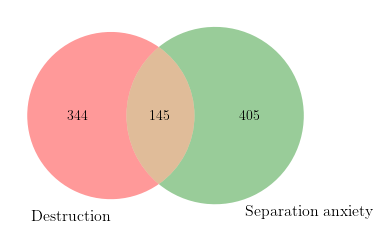

Chi-square Test of Independence:
chi2 = 127.052083, p = 1.81E-29, dof = 1
OR = 3.35, 95% CI: 2.69-4.18, n = 4114


In [24]:
fields = 'q02_main_9, q04_9'
labels = ['Destruction', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
boot_df = df.copy()

# Cross tabulate the relevant columns.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('B')
x, y = lbl.get_position()
lbl.set_position((x+0.15, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

### House soiling during owner absence and separation anxiety:

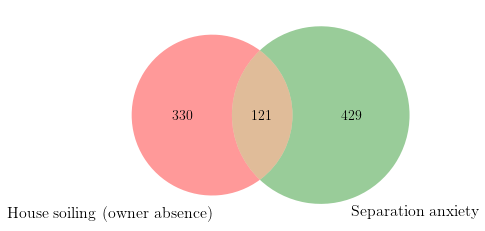

Chi-square Test of Independence:
chi2 = 79.239289, p = 5.50E-19, dof = 1
OR = 2.76, 95% CI: 2.19-3.48, n = 4114


In [25]:
fields = 'q06_situation_2, q04_9'
labels = ['House soiling (owner absence)', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
boot_df = df.copy()

# Cross tabulate the relevant columns.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('B')
x, y = lbl.get_position()
lbl.set_position((x+0.15, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

## <center>Fear/Anxiety and Aggression</center>

### Overall aggression and fearful/anxious behavior (Figure 3):

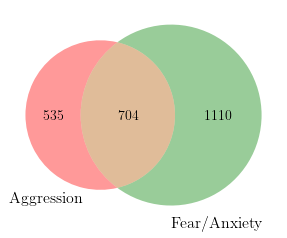

Chi-square Test of Independence:
chi2 = 116.490685, p = 3.71E-27, dof = 1
OR = 2.09, 95% CI: 1.83-2.40, n = 4114


In [26]:
fields = 'q02_main_1, q02_main_2'
labels = ['Aggression', 'Fear/Anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
boot_df = df.copy()
    
# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((x-0.1, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_3')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

### Owner directed aggression and fearful/anxious behavior (Figure 4):

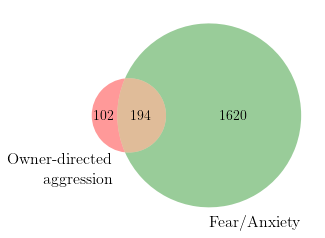

Chi-square Test of Independence:
chi2 = 59.514770, p = 1.21E-14, dof = 1
OR = 2.58, 95% CI: 2.01-3.31, n = 4114


In [27]:
fields = 'q03_main_1, q02_main_2'
labels = ['Owner-directed\naggression', 'Fear/Anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
boot_df = df.copy()   
    
# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((x-0.1, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_4')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

### Owner directed aggression and separation anxiety (Figure 5):

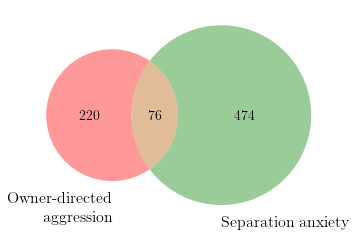

Chi-square Test of Independence:
chi2 = 41.709109, p = 1.06E-10, dof = 1
OR = 2.44, 95% CI: 1.85-3.22, n = 4114


In [28]:
fields = 'q03_main_1, q04_9'
labels = ['Owner-directed\naggression', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
boot_df = df.copy()

# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_5')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

## <center>Fear/Anxiety and Compulsive Behavior</center>

### Fear/anxiety and compulsion (Figure 6):

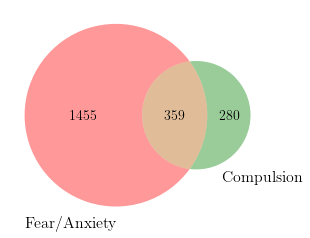

Chi-square Test of Independence:
chi2 = 44.843203, p = 2.13E-11, dof = 1
OR = 1.78, 95% CI: 1.50-2.11, n = 4114


In [29]:
fields = 'q02_main_2, q02_main_3'
labels = ['Fear/Anxiety', 'Compulsion']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
boot_df = df.copy()

# Cross tabulate the relevant columns.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('B')
x, y = lbl.get_position()
lbl.set_position((x+0.15, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_6')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

## <center>Coprophagia and Age</center>

In [30]:
fields = 'q02_main_8, q01_age_months'
labels = [FR.categories[7], 'age']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
df = df[np.isfinite(df['age'])]
boot_df = df.copy()

# Sort ages into two groups:
# 1: age <= 12 months
# 0: age > 12 months
def age_sort(row):
    if row['age'] <= 12:
        val = 1
    else:
        val = 0
    return val

df['age'] = df.apply(age_sort, axis=1)

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        df['age'] = df.apply(age_sort, axis=1)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-square Test of Independence:
chi2 = 0.670896, p = 4.13E-01, dof = 1
OR = 1.18, 95% CI: 0.79-1.76, n = 650


## <center>Overactivity/Hyperactivity and Age</center>

In [31]:
fields = 'q02_main_13, q01_age_months'
labels = [FR.categories[11], 'age']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
df = df[np.isfinite(df['age'])]
boot_df = df.copy()

# Sort ages into two groups:
# 1: age <= 12 months
# 0: age > 12 months
def age_sort(row):
    if row['age'] <= 12:
        val = 1
    else:
        val = 0
    return val

df['age'] = df.apply(age_sort, axis=1)

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        df['age'] = df.apply(age_sort, axis=1)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-square Test of Independence:
chi2 = 16.993133, p = 3.75E-05, dof = 1
OR = 2.58, 95% CI: 1.63-4.10, n = 650


## <center>Jumping and Mounting/Humping</center>

### Jumping and mounting/humping

In [32]:
fields = 'q02_main_6, q02_main_7'
labels = ['jumping', 'mounting']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df.apply(pd.to_numeric)
boot_df = df.copy()

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for jumping and mounting:
chi2 = 146.078445, p = 1.25E-33, dof = 1
OR = 3.32, 95% CI: 2.71-4.07, n = 4114


### Maleness and jumping up:

In [33]:
fields = 'q02_main_6, dog_sex'
labels = ['jumping', 'gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)
boot_df = df.copy()

def gender_to_binary_response(x):
    x = int(x)
    if x != 1:
        return 0
    return 1

df[labels[0]] = df[labels[0]].apply(
    lambda x: convert_to_binary_response(x))
df[labels[1]] = df[labels[1]].apply(
    lambda x: gender_to_binary_response(x))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        df[labels[0]] = df[labels[0]].apply(
            lambda x: convert_to_binary_response(x))
        df[labels[1]] = df[labels[1]].apply(
            lambda x: gender_to_binary_response(x))
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for jumping and gender:
chi2 = 0.013734, p = 9.07E-01, dof = 1
OR = 1.01, 95% CI: 0.88-1.16, n = 4100


### Maleness and mounting/humping:

In [34]:
fields = 'q02_main_7, dog_sex'
labels = ['mounting', 'gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)
boot_df = df.copy()

def gender_to_binary_response(x):
    x = int(x)
    if x != 1:
        return 0
    return 1

df[labels[0]] = df[labels[0]].apply(
    lambda x: convert_to_binary_response(x))
df[labels[1]] = df[labels[1]].apply(
    lambda x: gender_to_binary_response(x))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        df[labels[0]] = df[labels[0]].apply(
            lambda x: convert_to_binary_response(x))
        df[labels[1]] = df[labels[1]].apply(
            lambda x: gender_to_binary_response(x))
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for mounting and gender:
chi2 = 44.752657, p = 2.24E-11, dof = 1
OR = 2.01, 95% CI: 1.63-2.47, n = 4100


### Jumping and overactivity/hyperactivity:

In [35]:
fields = 'q02_main_6, q02_main_13'
labels = ['jumping', 'hyperactivity']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df.apply(pd.to_numeric)
boot_df = df.copy()

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for jumping and hyperactivity:
chi2 = 230.448605, p = 4.76E-52, dof = 1
OR = 4.09, 95% CI: 3.38-4.96, n = 4114


### Jumping and destruction:

In [36]:
fields = 'q02_main_6, q02_main_9'
labels = ['jumping', 'destruction']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df.apply(pd.to_numeric)
boot_df = df.copy()

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for jumping and destruction:
chi2 = 110.687381, p = 6.93E-26, dof = 1
OR = 2.73, 95% CI: 2.25-3.31, n = 4114


### Mounting/humping and overactivity/hyperactivity:

In [37]:
fields = 'q02_main_7, q02_main_13'
labels = ['mounting', 'hyperactivity']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df.apply(pd.to_numeric)
boot_df = df.copy()

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for mounting and hyperactivity:
chi2 = 54.878059, p = 1.28E-13, dof = 1
OR = 2.47, 95% CI: 1.93-3.15, n = 4114


## <center>Rolling in Repulsive Materials</center>

### Rolling in repulsive materials and coprophagia:

In [38]:
fields = 'q02_main_8, q02_main_10'
labels = ['coprophagia', 'rolling']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df.apply(pd.to_numeric)
boot_df = df.copy()

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for coprophagia and rolling:
chi2 = 180.101176, p = 4.61E-41, dof = 1
OR = 3.70, 95% CI: 3.03-4.52, n = 4114


## <center>Owner-directed Aggression</center>

### Owner-directed aggression and maleness:

In [39]:
fields = 'q03_main_1, dog_sex'
labels = ['owner-directed', 'gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)
boot_df = df.copy()

def gender_to_binary_response(x):
    x = int(x)
    if x != 1:
        return 0
    return 1

df[labels[0]] = df[labels[0]].apply(
    lambda x: convert_to_binary_response(x))
df[labels[1]] = df[labels[1]].apply(
    lambda x: gender_to_binary_response(x))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        df[labels[0]] = df[labels[0]].apply(
            lambda x: convert_to_binary_response(x))
        df[labels[1]] = df[labels[1]].apply(
            lambda x: gender_to_binary_response(x))
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for owner-directed and gender:
chi2 = 24.793805, p = 6.38E-07, dof = 1
OR = 1.85, 95% CI: 1.45-2.36, n = 4100


## <center>Running Away/Escaping</center>

### Impact of fear/anxiety on running away/escaping:

In [40]:
fields = 'q02_main_12, q02_main_2'
labels = ['escape', 'fear']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
boot_df = df.copy()

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for escape and fear:
chi2 = 24.796898, p = 6.37E-07, dof = 1
OR = 1.65, 95% CI: 1.35-2.01, n = 4114


### Running away/escaping confinement and fear/anxiety:

In [41]:
fields = 'q14_conf, q02_main_2'
labels = ['escape_conf', 'fear']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
boot_df = df.copy()

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

def get_bootstrap_odds_ratio_ci(data, count=10, alpha=0.95):
    start = timer()
    arr = np.array([])
    for i in range(count):
        df = data.sample(len(data.index), replace=True)
        contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
        odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(contingency)
        arr = np.append(arr, odds)
    arr = np.sort(arr)
    lower = (1-alpha)/2
    upper = alpha+lower
    print('95%% CI: %.2f-%.2f' %(arr[int(lower * len(arr))], arr[int(upper * len(arr))]))
    end = timer()
    print('\nbootstrap time: %.2f' %(end-start))

if ODDS_RATIO_CI:
    get_bootstrap_odds_ratio_ci(boot_df, count=NITER)

Chi-squared Test of Independence for escape_conf and fear:
chi2 = 0.144352, p = 7.04E-01, dof = 1
OR = 0.93, 95% CI: 0.64-1.36, n = 439


In [42]:
NOTEBOOK_END = timer()
print('\nNOTEBOOK RUN TIME: %.2f sec' %(NOTEBOOK_END-NOTEBOOK_START))


NOTEBOOK RUN TIME: 1100.95 sec
